In [1]:
from keras.layers import LSTM,Dense,Input,Lambda,Reshape,Embedding,concatenate,Conv2D,MaxPooling2D,Flatten
from keras.layers import Concatenate
from keras.models import Model
import tensorflow as tf
from keras import backend as K
import numpy as np
from keras.optimizers import rmsprop
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Prepare data set

In [2]:
n_x,T,n_a,n_y=1,7,32,4
X_train=[
    [[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[0],[1],[0],[1]],
    [[0],[0],[2],[2],[0],[0],[0]],
    [[3],[0],[3],[0],[0],[0],[0]],
    [[0],[0],[0],[0],[0],[1],[0]],
    [[1],[0],[0],[0],[0],[0],[0]],
    [[2],[0],[0],[0],[0],[0],[0]],
    [[3],[0],[3],[0],[0],[0],[0]]
]
X_train=np.array(X_train)
Y_train=to_categorical([0,1,2,3,1,1,2,3],4)
print(Y_train)


[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [3]:
def myModel():
    X_Input=Input(shape=(T,n_x,),name='myinput')
    X=X_Input
    
    X=LSTM(n_a,name='mylstm')(X)
    X=Dense(n_y,activation='softmax',name='myprediction')(X)
    model=Model(inputs=X_Input,outputs=X)
    model.summary()
    return model

In [4]:
model=myModel()
model.compile(optimizer=rmsprop(0.01),loss=categorical_crossentropy,metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myinput (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
mylstm (LSTM)                (None, 32)                4352      
_________________________________________________________________
myprediction (Dense)         (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 49ms/step - loss: 1.4039 - acc: 0.1250
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 1.2772 - acc: 0.3750
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 1.1085 - acc: 0.6250
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8783 - acc: 0.6250
Epoch 5/100
8/8 [==================

In [5]:
x=np.array([[[3],[0],[0],[0],[0],[0],[0]]])
# print(model.predict(x).shape)
np.argmax(model.predict(x))


2

# Multi-input and multi-output models
from https://keras.io/getting-started/functional-api-guide/#getting-started-with-the-keras-functional-api

In [6]:
# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
K.clear_session()
main_input = Input(shape=(100,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)  #(100,512,)
a0=Input(shape=(32,),name='a0')
c0=Input(shape=(32,),name='c0')

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32,return_state=False,return_sequences=False)(x,initial_state=[a0,c0]) #(32,)

auxiliary_input = Input(shape=(5,), name='aux_input')
x = concatenate([lstm_out, auxiliary_input])
print(x)

Tensor("concatenate_1/concat:0", shape=(?, 37), dtype=float32)


# another example from kera.io(Shared layers)
Another good use for the functional API are models that use shared layers. Let's take a look at shared layers.

Let's consider a dataset of tweets. We want to build a model that can tell whether two tweets are from the same person or not (this can allow us to compare users by the similarity of their tweets, for instance).

One way to achieve this is to build a model that encodes two tweets into two vectors, concatenates the vectors and then adds a logistic regression; this outputs a probability that the two tweets share the same author. The model would then be trained on positive tweet pairs and negative tweet pairs.

Because the problem is symmetric, the mechanism that encodes the first tweet should be reused (weights and all) to encode the second tweet. Here we use a shared LSTM layer to encode the tweets.


In [7]:
tweet_a = Input(shape=(280, 256))
tweet_b = Input(shape=(280, 256))
# This layer can take as input a matrix
# and will return a vector of size 64,global weight
shared_lstm = LSTM(64) #this is a global weight
# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)
print('encoded_a shoule have shape 64')
print(encoded_a.shape)
print('encoded_b shoule have shape 64')
print(encoded_b.shape)

# We can then concatenate the two vectors:
merged_vector = concatenate([encoded_a, encoded_b], axis=-1)
print('after merged,should have shape 128')
print(merged_vector.shape)
# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.fit([data_a, data_b], labels, epochs=10)

encoded_a shoule have shape 64
(?, 64)
encoded_b shoule have shape 64
(?, 64)
after merged,should have shape 128
(?, 128)


# layer's node

In [8]:
tweet_a=Input(shape=(30,1000,))
slstm=LSTM(32)
encode_a=slstm(tweet_a)
print(slstm.output)
assert slstm.output==encode_a
slstm(tweet_a)

print(slstm.get_output_at(0))
print(slstm.get_output_at(1))

Tensor("lstm_3/TensorArrayReadV3:0", shape=(?, 32), dtype=float32)
Tensor("lstm_3/TensorArrayReadV3:0", shape=(?, 32), dtype=float32)
Tensor("lstm_3_1/TensorArrayReadV3:0", shape=(?, 32), dtype=float32)


## Shared vision model
This model reuses the same image-processing module on two inputs, to classify whether two MNIST digits are the same digit or different digits.

In [9]:
# First, define the vision modules
digit_input = Input(shape=(27, 27, 1))
x = Conv2D(64, (3, 3))(digit_input)
print('shape should be 25x25x64')
print(x.shape)
x = Conv2D(64, (3, 3))(x)
print('shape should be 23x23x64')
print(x.shape)
x = MaxPooling2D((2, 2))(x)
print('shape should be 12x12x64')
print(x.shape)
out = Flatten()(x)

vision_model = Model(digit_input, out)

# # Then define the tell-digits-apart model
digit_a = Input(shape=(27, 27, 1))
digit_b = Input(shape=(27, 27, 1))

# # The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)
print('shape should be 7744')
print(out_a.shape)
concatenated = concatenate([out_a, out_b])
out = Dense(1, activation='sigmoid')(concatenated)
classification_model = Model([digit_a, digit_b], out)


classification_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

shape should be 25x25x64
(?, 25, 25, 64)
shape should be 23x23x64
(?, 23, 23, 64)
shape should be 12x12x64
(?, 11, 11, 64)
shape should be 7744
(?, ?)


# Got me crazy,do again we fouce!

In [10]:
K.clear_session()

In [11]:
m,hidden,classes,T=10,32,7,5
def prepareData():
    X=np.random.randint(0,classes,size=(m,T))
    Y=np.random.randint(0,classes,size=(T,m))
    X=to_categorical(X,classes) #shape m,T,Classes
    Y=to_categorical(Y,classes) #shape T,m,Classes
    assert X.shape==(m,T,classes)
    assert Y.shape==(T,m,classes)
    Y=list(Y)
    
    a0=np.zeros((m,hidden))
    c0=np.zeros((m,hidden))
    return X,Y,a0,c0
X,Y,a0,c0=prepareData()

In [12]:
print(X.shape)

(10, 5, 7)


In [13]:
cell=LSTM(units=hidden,name='lstm_01',return_state=True)
densor=Dense(units=classes,activation='softmax')

In [14]:
def myModel():
    X=Input(shape=(T,classes),name='X')
    a0=Input(shape=(hidden,),name='a0')
    c0=Input(shape=(hidden,),name='c0')
    
    a,c=a0,c0
    outs=[]
    for t in range(T):
        x=Lambda(lambda x: x[:,t:t+1,:],name='x'+str(t))(X)
        a,_,c=cell(x,initial_state=[a,c])
        y=densor(a)
        outs.append(y)
    model=Model(inputs=[X,a0,c0],outputs=outs)
#     model.summary()
    return model

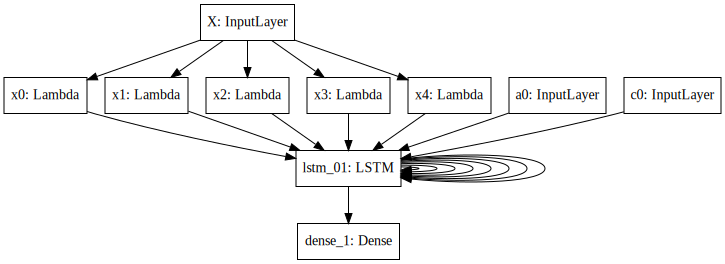

In [15]:
model=myModel()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [86]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit([X,a0,c0],Y,batch_size=2,epochs=30)

Epoch 1/30
10/10 [==============================] - 2s 216ms/step - loss: 9.5856 - dense_20_loss: 1.9156 - dense_20_acc: 0.3000 - dense_20_acc_1: 0.3000 - dense_20_acc_2: 0.3000 - dense_20_acc_3: 0.4000 - dense_20_acc_4: 0.3000  
Epoch 2/30
10/10 [==============================] - 0s 4ms/step - loss: 9.5450 - dense_20_loss: 1.9056 - dense_20_acc: 0.3000 - dense_20_acc_1: 0.3000 - dense_20_acc_2: 0.3000 - dense_20_acc_3: 0.4000 - dense_20_acc_4: 0.3000
Epoch 3/30
10/10 [==============================] - 0s 4ms/step - loss: 9.5161 - dense_20_loss: 1.9014 - dense_20_acc: 0.3000 - dense_20_acc_1: 0.3000 - dense_20_acc_2: 0.2000 - dense_20_acc_3: 0.5000 - dense_20_acc_4: 0.4000
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 9.4943 - dense_20_loss: 1.8951 - dense_20_acc: 0.3000 - dense_20_acc_1: 0.2000 - dense_20_acc_2: 0.2000 - dense_20_acc_3: 0.5000 - dense_20_acc_4: 0.4000    
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 9.4709 - dense_2

# define above model using different stype,be care,never using slice the tensor return by keras's layers,use a Lambda Layer wrap it!!! 

In [87]:
cell=LSTM(units=hidden,name='lstm_01',return_sequences=True)
densor=Dense(units=classes,activation='softmax')

def myGenModel():
    X=Input(shape=(T,classes),name='X')
    a0=Input(shape=(hidden,),name='a0')
    c0=Input(shape=(hidden,),name='c0')
    a=cell(X,initial_state=[a0,c0])
    outs=[]
    for t in range(T):
        #a is a tensor return by LSTM(),so should not split it a[:,t,:] directly,wrap it up!
        la=Lambda(lambda x:x[:,t,:],name='a_out'+str(t+1))(a)
        out=densor(la)
        outs.append(out)
    model=Model(inputs=[X,a0,c0],outputs=outs)
    return model

In [88]:
model=myGenModel()

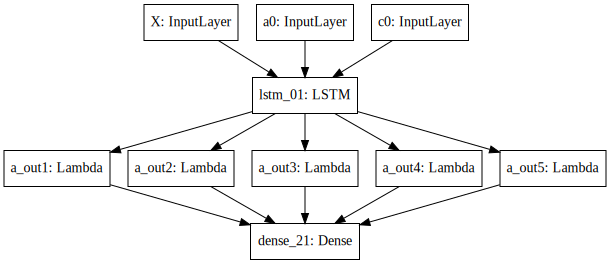

In [89]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [90]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit([X,a0,c0],Y,batch_size=2,epochs=30)

Epoch 1/30
10/10 [==============================] - 1s 141ms/step - loss: 9.6678 - dense_21_loss: 1.9423 - dense_21_acc: 0.2000 - dense_21_acc_1: 0.0000e+00 - dense_21_acc_2: 0.3000 - dense_21_acc_3: 0.4000 - dense_21_acc_4: 0.1000  
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 9.6285 - dense_21_loss: 1.9333 - dense_21_acc: 0.2000 - dense_21_acc_1: 0.0000e+00 - dense_21_acc_2: 0.2000 - dense_21_acc_3: 0.6000 - dense_21_acc_4: 0.2000        
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 9.6072 - dense_21_loss: 1.9331 - dense_21_acc: 0.4000 - dense_21_acc_1: 0.1000 - dense_21_acc_2: 0.2000 - dense_21_acc_3: 0.5000 - dense_21_acc_4: 0.2000        
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 9.5820 - dense_21_loss: 1.9243 - dense_21_acc: 0.4000 - dense_21_acc_1: 0.1000 - dense_21_acc_2: 0.2000 - dense_21_acc_3: 0.5000 - dense_21_acc_4: 0.3000        
Epoch 5/30
10/10 [==============================] - 0s 3ms/s

# Now Try define a bi-dirction model
## you find Concatenate is useful <a href='https://keras.io/layers/merge/#concatenate'>hint</a>

In [116]:
cell_forward=LSTM(units=hidden,name='lstm_forward',return_sequences=True)
cell_backward=LSTM(units=hidden,name='lstm_backward',return_sequences=True)
densor=Dense(units=classes,activation='softmax')
concat=Concatenate(axis=1,name='concat')
def myBiModel():
    X=Input(shape=(T,classes),name='X')
    X_reverse=Lambda(lambda x:K.reverse(x,1),name='X_reverse')(X)

    a_forward=cell_forward(X)
    a_backward=cell_backward(X_reverse)
    outs=[]
    for t in range(T):
        #a_forward is a tensor return by LSTM(),so should not split it a_forward[:,t,:] 
        #directly,wrap it up!,output shape [m,n_a]
        fa=Lambda(lambda x:x[:,t,:],name='forward_out'+str(t+1))(a_forward)
        ba=Lambda(lambda x:x[:,t,:],name='backward_out'+str(t+1))(a_backward)
        
        
        cn=concat([fa,ba])
        out=densor(cn)
        outs.append(out)
    model=Model(inputs=X,outputs=outs)
    return model

In [117]:
model=myBiModel()

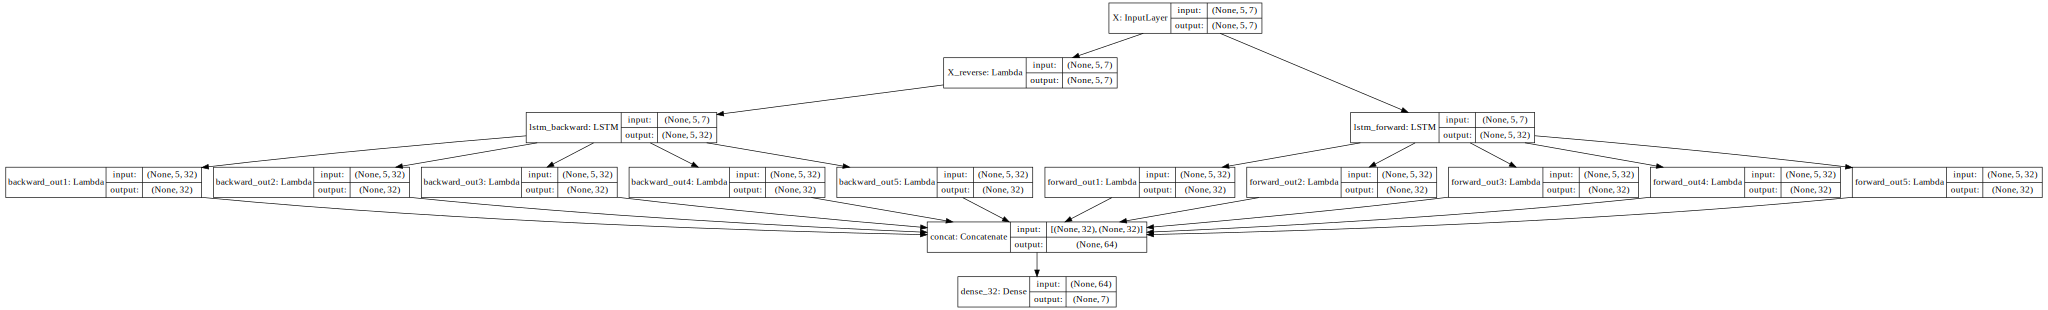

In [122]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [124]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X,Y,batch_size=2,epochs=30)

Epoch 1/30
10/10 [==============================] - 2s 223ms/step - loss: 9.7496 - dense_32_loss: 1.9655 - dense_32_acc: 0.1000 - dense_32_acc_1: 0.1000 - dense_32_acc_2: 0.1000 - dense_32_acc_3: 0.1000 - dense_32_acc_4: 0.0000e+00          
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 9.6860 - dense_32_loss: 1.9429 - dense_32_acc: 0.2000 - dense_32_acc_1: 0.0000e+00 - dense_32_acc_2: 0.1000 - dense_32_acc_3: 0.2000 - dense_32_acc_4: 0.1000
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 9.6437 - dense_32_loss: 1.9364 - dense_32_acc: 0.3000 - dense_32_acc_1: 0.0000e+00 - dense_32_acc_2: 0.1000 - dense_32_acc_3: 0.3000 - dense_32_acc_4: 0.1000    
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 9.6088 - dense_32_loss: 1.9251 - dense_32_acc: 0.4000 - dense_32_acc_1: 0.1000 - dense_32_acc_2: 0.1000 - dense_32_acc_3: 0.4000 - dense_32_acc_4: 0.3000    
Epoch 5/30
10/10 [==============================] - 0s 3ms/step 